# Installing required libraries when working in Google Colab.

In [1]:
!pip install pyyaml==5.1
!pip install torch==1.9.0+cu102 torchvision==0.10.0+cu102 -f https://download.pytorch.org/whl/torch_stable.html
!pip install detectron2 -f https://dl.fbaipublicfiles.com/detectron2/wheels/cu102/torch1.9/index.html

In [ ]:
import torch, torchvision
print(torch.__version__, torch.cuda.is_available())
assert torch.__version__.startswith("1.9") 

1.9.0+cu102 True


In [ ]:
import detectron2
from detectron2.utils.logger import setup_logger
setup_logger()

import numpy as np
import os, json, cv2, random
import math
from PIL import Image
from google.colab.patches import cv2_imshow

from detectron2 import model_zoo
from detectron2.engine import DefaultPredictor
from detectron2.config import get_cfg
from detectron2.utils.visualizer import Visualizer
from detectron2.data import MetadataCatalog, DatasetCatalog
from detectron2.evaluation import COCOEvaluator

# Loading pre-trained models

In [306]:
# Segmenting arrow model
cfg = get_cfg()
cfg.merge_from_file(model_zoo.get_config_file('COCO-InstanceSegmentation/mask_rcnn_R_50_FPN_3x.yaml'))
cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.5 # Set threshold for this model
cfg.MODEL.WEIGHTS = '.../segment_arrow.pth' # Write your path to the file
cfg.MODEL.ROI_HEADS.NUM_CLASSES = 2
predictor_arrow = DefaultPredictor(cfg)

In [ ]:
# Model detecting numbers on the clock
cfg_time = get_cfg()
cfg_time.merge_from_file(model_zoo.get_config_file('COCO-Detection/faster_rcnn_X_101_32x8d_FPN_3x.yaml'))
cfg_time.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.8 # Set threshold for this model
cfg_time.MODEL.WEIGHTS = '.../num_detect.pth' # Write your path to the file
cfg_time.MODEL.ROI_HEADS.NUM_CLASSES = 13
predictor_num = DefaultPredictor(cfg_time)

In [ ]:
# Model for localizing clock position.
cfg_detect = get_cfg()
cfg_detect.merge_from_file(model_zoo.get_config_file("COCO-Detection/faster_rcnn_R_50_FPN_3x.yaml"))
cfg_detect.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.8
cfg_detect.MODEL.WEIGHTS = model_zoo.get_checkpoint_url("COCO-Detection/faster_rcnn_R_50_FPN_3x.yaml")
predictor_clock  = DefaultPredictor(cfg_detect)

model_final_280758.pkl: 167MB [00:04, 35.2MB/s]                           


# Functions for calculating time

In [ ]:
# Renaming class names
trans_class = {1: 1, 8: 2, 9: 3, 10: 4, 11: 5, 12: 6, 2: 7, 3: 8, 4: 9, 5: 10, 6: 11, 7: 0}

In [ ]:
def best_detect_num(outputs_num):
    '''
    Find the coordinates of the most probable number
    '''
    best_class = outputs_num['instances'].pred_classes.cpu().numpy()[0]
    best_class = trans_class[best_class]
    xy0 = outputs_num['instances'].pred_boxes.tensor.cpu().numpy()[0]
    x_c = 0.5 * (xy0[0] + xy0[2])
    y_c = - 0.5 * (xy0[1] + xy0[3])
    return best_class, x_c, y_c

In [ ]:
def len_line(x1, y1, x2, y2):
    '''
    Finds the length of the line
    '''
    return ((x2 - x1)**2 + (y2 - y1)**2)**0.5

In [ ]:
def trr(a):
    '''
    :param a: Arrow Mask
    :return: Coordinates, first and last coordinate x, arrow linear equation coefficients
    '''
    w, h = a.shape
    coord = []
    sx = 0
    sx2 = 0
    sxy = 0
    sy= 0
    max = 9999
    min = 0
    flag = 1
    for i in range(h):
        for j in range(w):
            if a[j][i]:
                if flag:
                    min = i
                    flag = 0
                coord.append([i, -j])
                sx += i
                sy += -j
                sxy += i * (- j)
                sx2 += i**2
                max = i
    n = len(coord)
    a1 = (n * sxy - sx * sy) / (n * sx2 - (sx)**2)
    b1 = (sy - a1 * sx) / n
    return coord, max, min, a1, b1

In [ ]:
def arr(a, b, x):
    '''
    :return: Linear Equation
    '''
    return a * x + b

In [ ]:
def calculate_angle(a, b, c):
    """
    :param a: First point
    :param b: Middle point
    :param c: Last point
    :return: Angle between three points
    """
    a = np.array(a)  # First
    b = np.array(b)  # Mid
    c = np.array(c)  # End

    radians = np.arctan2(c[1] - b[1], c[0] - b[0]) - np.arctan2(a[1] - b[1], a[0] - b[0])
    angle = np.abs(radians * 180.0 / np.pi)

    if angle > 180.0:
        angle = 360 - angle

    return angle

In [ ]:
def coord_hm(mask_m, mask_h, x0, y0):
    '''
    :return: Coordinates of the ends of the hour and minute hands
    '''
    coord_m, max_m, min_m, a_m, b_m = trr(mask_m)
    coord_h, max_h, min_h, a_h, b_h = trr(mask_h)
    if len_line(min_h, arr(a_h, b_h, min_h), x0, y0) > len_line(max_h, arr(a_h, b_h, max_h), x0, y0):
        xh, yh = min_h, arr(a_h, b_h, min_h)
    else:
        xh, yh = max_h, arr(a_h, b_h, max_h)
    if len_line(min_m, arr(a_m, b_m, min_m), x0, y0) > len_line(max_m, arr(a_m, b_m, max_m), x0, y0):
        xm, ym = min_m, arr(a_m, b_m, min_m)
    else:
        xm, ym = max_m, arr(a_m, b_m, max_m)
    if len_line(xm, ym, x0, y0) < len_line(xh, yh, x0, y0):
        xm, ym, xh, yh = xh, yh, xm, ym
    return xh, yh, xm, ym

In [ ]:
def mask(out_mask, out_class):
    """
    :return: Hour and minute hand masks
    """
    out_mask = outputs_arrow['instances'].pred_masks.cpu().numpy()
    out_class = outputs_arrow['instances'].pred_classes.cpu().numpy()
    if out_class.shape[0] >= 1:
            mask_h = out_mask[0]
            mask_m = out_mask[1]
    else:
        print('Стрелки не нашлись :(')
    return mask_h, mask_m

In [323]:
def angle_12_3(mask_m, mask_h, outputs_num):
    '''
    return:
    angle_hour12(angle_min12) - The angle between the hour (minute) hand and the number 12
    angle_hour3(angle_min3) - The angle between the hour (minute) hand and the number 3
    '''
    best_class, x_c, y_c = best_detect_num(outputs_num)

    coord_m, max_m, min_m, a_m, b_m = trr(mask_m)
    coord_h, max_h, min_h, a_h, b_h = trr(mask_h)

    # Circle center coordinates
    x0 = (b_h - b_m) / (a_m - a_h)
    y0 = a_m * x0 + b_m

    # Arrow head coordinates
    xh, yh, xm, ym = coord_hm(mask_m, mask_h, x0, y0)

    # The angle through which the arrows are rotated relative to the 0X axis in the counterclockwise direction
    angle_h = math.degrees(math.acos((xh - x0) / len_line(xh, yh, x0, y0)))
    angle_m = math.degrees(math.acos((xm - x0) / len_line(xm, ym, x0, y0)))
    if yh < y0:
        angle_h = - angle_h
    if ym < y0:
        angle_m = - angle_m

    # The coordinates of the numbers 12 and 3 on the dial
    angle_class12 = math.degrees(math.acos((x_c - x0) / len_line(x_c, y_c, x0, y0)))
    if y_c < y0:
        angle_class12 = - angle_class12
    if angle_class12 < 0:
        angle_class12 = 360 + angle_class12
    angle_class12 = angle_class12 - (12 - best_class) * 30
    if angle_class12 < 0:
        angle_class12 = 360 + angle_class12
    angle_class3 = angle_class12 - 90
    angle_class12 = math.radians(angle_class12)
    angle_class3  = math.radians(angle_class3)

    x12 = x0 + math.cos(angle_class12)
    y12 = y0 + math.sin(angle_class12)
    x3 = x0 + math.cos(angle_class3)
    y3 = y0 + math.sin(angle_class3)


    angle_hour12 = calculate_angle((x12, y12), (x0, y0), (xh, yh))
    angle_hour3 = calculate_angle((x3, y3), (x0, y0), (xh, yh))
    angle_min12 = calculate_angle((x12, y12), (x0, y0), (xm, ym))
    angle_min3 = calculate_angle((x3, y3), (x0, y0), (xm, ym))
    return angle_hour12, angle_hour3, angle_min12, angle_min3

In [322]:
def time(im, outputs_arrow, outputs_num):
    '''
    Function called to predict time
    :return: time
    '''
    mask_h, mask_m = mask(outputs_arrow, outputs_num)
    
    angle_hour12, angle_hour3, angle_min12, angle_min3 = angle_12_3(mask_m, mask_h, outputs_num)

    # Determining the time in the corners
    for i in range(30):
        if i * 6 <= angle_min12 < (i + 1) * 6:
            m = i
    if angle_min3 > 90:
        m = 59 - m
          
    for i in range(6):
        if i * 30 <= angle_hour12 < (i + 1) * 30:
            h = i
    if angle_hour3 > 90:
        h = 11 - h

    # Checking the hour prediction at minute < 10 or minute > 50
    hour_correct = 5    
    for i in range(6):
        if i * 30 - hour_correct <= angle_hour12 < (i + 1) * 30 - hour_correct:
            h_corr_m = i
        if i * 30 + hour_correct <= angle_hour12 < (i + 1) * 30 + hour_correct:
            h_corr_p = i

    if m <= 10:
        if angle_hour12 <= 25:
            return 0, m
        elif angle_hour12 >= 165:
            return 6, m
    elif m >= 50:
        if angle_hour12 <= 25:
            return 11, m
        elif angle_hour12 >= 165:
            return 5, m

    if m <= 10:
        if angle_hour3 < 90:
            if h_corr_m > h:
                return h_corr_m, m
        elif h_corr_p < h:
            return 11 - h_corr_p, m
    elif m >= 50:
        if angle_hour3 < 90:
            if h_corr_p < h:
                return h_corr_p, m
        elif angle_hour3 > 90:
            if h_corr_m > h:
                return 11 - h_corr_m, m

    return h, m

In [287]:
def croop(im, outputs_clock, pd = 0.1):

    clock_class = outputs_clock['instances'].pred_classes.cpu().numpy()
    clock_box = outputs_clock['instances'].pred_boxes.tensor.cpu().numpy()
    for i in range(len(clock_class)):
        if clock_class[i] == 74:
            box = clock_box[i]
            break
    x1, y1, x2, y2 = box
    ly, lx, _ = im.shape
    dx = x2 - x1
    dy = y2 - y1
    if x1 - pd * dx > 0:
        x1 -= pd * dx
    else:
        x1 = 0

    if y1 - pd * dy > 0:
        y1 -= pd * dy
    else:
        y1 = 0

    if x2 + pd * dx < lx:
        x2 += pd * dx
    else:
        x2 = lx

    if y2 + pd * dx < ly:
        y2 += pd * dx
    else:
        y2 = ly

    img = im[int(y1):int(y2), int(x1):int(x2), :]
    return img


# Run this cell for prediction

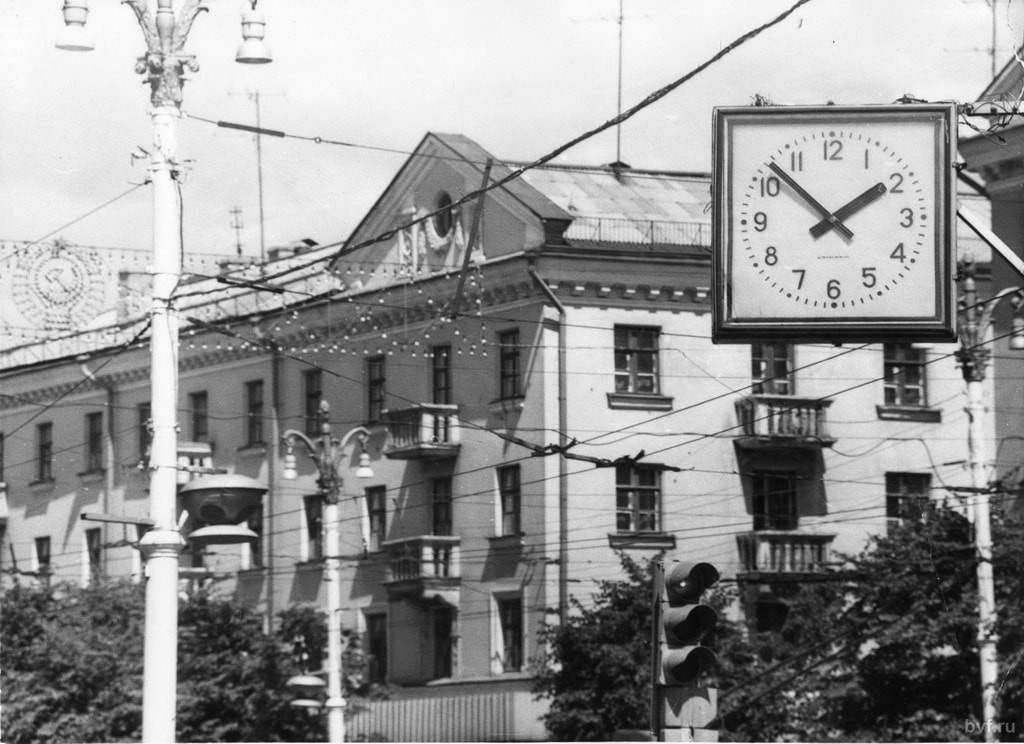

время 1:52


In [333]:
im = cv2.imread('imgs/12.jpg')
cv2_imshow(im)
outputs_clock = predictor_clock(im)
im = croop(im, outputs_clock, pd=0.05)

outputs_arrow = predictor_arrow(im)
outputs_num = predictor_num(im)
h, m = time(im, outputs_arrow, outputs_num)
print('время ' + str(h) + ':' + str(m))

## If you want to visualize

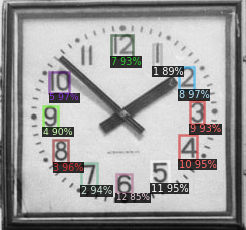

In [313]:
v = Visualizer(im[:, :, ::-1],
                   scale=1.0, 
    )
out_num = v.draw_instance_predictions(outputs_num["instances"].to("cpu"))
cv2_imshow(out_num.get_image()[:, :, ::-1])

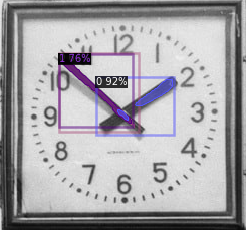

In [314]:
v = Visualizer(im[:, :, ::-1],
                   scale=1.0, 
    )
out_arrow = v.draw_instance_predictions(outputs_arrow["instances"].to("cpu"))
cv2_imshow(out_arrow.get_image()[:, :, ::-1])

In [317]:
mask_h, mask_m = mask(outputs_arrow, outputs_num)
coord_m, max_m, min_m, a_m, b_m = trr(mask_m)
coord_h, max_h, min_h, a_h, b_h = trr(mask_h)


In [318]:
color = (0, 255, 0)
thickness = 3
image = cv2.line(im, (int(min_h), -int(arr(a_h, b_h, min_h))), (int(max_h), -int(arr(a_h, b_h, max_h))), color, thickness)
image = cv2.line(im, (int(min_m), -int(arr(a_m, b_m, min_m))), (int(max_m), -int(arr(a_m, b_m, max_m))), color, thickness)

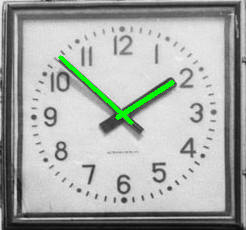

In [319]:
cv2_imshow(im)